# A comprehensive study of DPNets on the logistic map

In [1]:
%load_ext autoreload
#Configs
import ml_confs as mlcfg
configs = mlcfg.from_file('configs.yaml', register_jax_pytree=False)

In [125]:
%autoreload 2
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
from scipy.integrate import romb
#Set plotting styles
import scienceplots
plt.style.use(['nature', 'retro'])
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9

#Kooplearn imports
from kooplearn.abc import BaseModel, FeatureMap
from kooplearn.models.feature_maps import ConcatenateFeatureMaps
from kooplearn.datasets import LogisticMap

## Creating the standard dataset

In [60]:
logistic = LogisticMap(N = configs.N)

## Setting up an evaluation scheme.

### Population estimators
As we are able to compute everything for this system, we evaluate the performance of `DPNets` in two stages. In the first stage we take three different feature maps:
1. Hermite polynomials up to order $\ell$
2. `VAMPNets` with latent dimension $\ell$ (MLP architecture tbd)
3. `DPNets` with latend dimension $\ell$ (MLP architecture tbd)

Given $\phi \colon [0, 1]\to \mathbb{R}^{\ell}$, we evaluate $C_{ij} := \int_{0}^{1} \phi_{i}(x)\phi_{j}(x) \pi(dx)$, where $\pi$ is the invariant distribution. And the cross covariance $C_{ij}^{\times} := \int_{0}^{1} \phi_{i}(x)\phi_{j}(y) \pi(dx)p(x, dy) = \sum_{n = 0}^{N}\left(\int_{0}^{1} \phi_{i}(x)\alpha_{n}(x)\pi(dx)\right)\left(\int_{0}^{1} \phi_{j}(y)\beta_{n}(y)dy\right)$. As the kernel is separable, I just need to compute $2(N + 1)$ single integrals. 

Now, the OLS Transfer operator estimator is $G_{{\rm OLS}} = C^{\dagger}C^{\times}$, from which I can compute:
1. Directed Hausdorff spectral distance
2. Approximation error $\Vert [I - P_{\mathcal{H}}]\mathcal{T}|_{\mathcal{H}}\Vert$, for which $\mathcal{P}$ and $\mathcal{S}$ are proxies.
3. VAMP-score $\mathcal{P}$ + something related to metric distortion. An example could be $\mathcal{P}/\kappa (C)$

### Empirical estimators
In the second stage we pull into the ring every Koopman estimator we have and we compute, from data:

- Directed Hausdorff distance as a metric for the spectral estimation.
- MAE on 1-step ahead conditional expectation. Even if the system is stochastic, since it is of the form $X_{t + 1} = F(X_t) + \xi_{t}$ where $\xi_{t}$ is zero-mean, the expected value conditioned on $X_t = x$ is just $F(x)$.

# Population validators

In [85]:
def population_cov(feature_map: FeatureMap, logistic_map: LogisticMap, pow_of_two_k: int = 12):
    x = np.linspace(0, 1, 2**pow_of_two_k + 1)
    vals, lv = logistic_map.eig(eval_left_on=x)
    perron_eig_idx = np.argmax(np.abs(vals))
    pi = lv[:, perron_eig_idx]
    assert np.isreal(pi).all()
    pi = pi.real
    pi_mass = romb(pi, dx = 1/2**pow_of_two_k)
    pi = pi/pi_mass
    assert np.isclose(romb(pi, dx = 1/2**pow_of_two_k), 1)
    phi = feature_map(x)
    C_unfolded = phi.reshape(2**pow_of_two_k + 1, -1, 1)*phi.reshape(2**pow_of_two_k + 1, 1, -1)*pi.reshape(-1, 1, 1)
    return romb(C_unfolded, dx = 1/2**pow_of_two_k, axis=0)

def population_cross_cov(feature_map: FeatureMap, logistic_map: LogisticMap, pow_of_two_k: int = 12):
    x = np.linspace(0, 1, 2**pow_of_two_k + 1)
    vals, lv = logistic_map.eig(eval_left_on=x)
    perron_eig_idx = np.argmax(np.abs(vals))
    pi = lv[:, perron_eig_idx]
    assert np.isreal(pi).all()
    pi = pi.real
    pi_mass = romb(pi, dx = 1/2**pow_of_two_k)
    pi = pi/pi_mass
    assert np.isclose(romb(pi, dx = 1/2**pow_of_two_k), 1)
    phi = feature_map(x)

    alphas = np.stack([logistic_map.noise_feature_composed_map(x, n) for n in range(logistic_map.N + 1)], axis = 1)
    betas = np.stack([logistic_map.noise_feature(x, n) for n in range(logistic_map.N + 1)], axis = 1)

    C_alpha_unfolded = phi.reshape(2**pow_of_two_k + 1, -1, 1)*alphas.reshape(2**pow_of_two_k + 1, 1, -1)*pi.reshape(-1, 1, 1)
    C_beta_unfolded = phi.reshape(2**pow_of_two_k + 1, -1, 1)*betas.reshape(2**pow_of_two_k + 1, 1, -1)

    C_alpha = romb(C_alpha_unfolded, dx = 1/2**pow_of_two_k, axis=0)
    C_beta = romb(C_beta_unfolded, dx = 1/2**pow_of_two_k, axis=0)
    
    return C_alpha@(C_beta.T)

In [86]:
def init_ChebyT(max_order: int = 3):
    def scaled_chebyt(n, x):
        return scipy.special.eval_chebyt(n, 2*x - 1)
    fn_list = [partial(scaled_chebyt, n) for n in range(max_order + 1)]
    return ConcatenateFeatureMaps(fn_list)    

In [74]:
cheby_T = init_ChebyT(max_order=3)


In [100]:
cov = population_cov(cheby_T, logistic)
cross_cov = population_cross_cov(cheby_T, logistic)

OLS_estimator = np.linalg.solve(cov, cross_cov)
eigs_OLS = np.linalg.eigvals(OLS_estimator)

eigs = logistic.eig()

In [130]:
def directed_hausdorff_distance(pred: np.ndarray, reference: np.ndarray, return_spectral_distances: bool = False):
    """One-sided hausdorff distance between sets.
    """
    pred = np.asanyarray(pred)
    reference = np.asanyarray(reference)
    assert pred.ndim == 1
    assert reference.ndim == 1

    distances = np.zeros((pred.shape[0], reference.shape[0]), dtype=np.float64)
    for pred_idx, pred_pt in enumerate(pred):
        for reference_idx, reference_pt in enumerate(reference):
            distances[pred_idx, reference_idx] = np.abs(pred_pt - reference_pt)
    hausdorff_dist =  np.max(np.min(distances, axis=1))
    if return_spectral_distances:
        return hausdorff_dist, np.min(distances, axis=1)
    else:
        return hausdorff_dist

Directed Hausdorff distance: 0.253


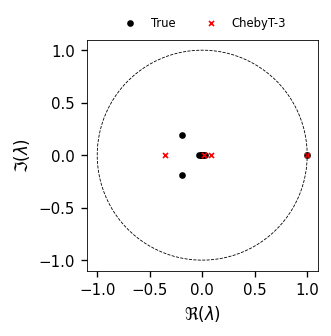

In [131]:
fig, ax = plt.subplots(1, 1)
#Draw unit circle
ax.plot(np.cos(np.linspace(0, 2*np.pi, 100)), np.sin(np.linspace(0, 2*np.pi, 100)), c='k', linestyle='--', lw=0.5)
ax.scatter(eigs.real, eigs.imag, c='k', label='True')
ax.scatter(eigs_OLS.real, eigs_OLS.imag, marker='x', c='r', label='ChebyT-3')

lim = 1.1
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)

ax.legend(loc='lower center', bbox_to_anchor=(0, 1, 1, 0), ncol=2, frameon=False)

ax.set_xlabel(r'$\Re(\lambda)$')
ax.set_ylabel(r'$\Im(\lambda)$')
ax.set_aspect('equal')

print(f"Directed Hausdorff distance: {directed_hausdorff_distance(eigs, eigs_OLS):.3f}")